In [1]:
import os
os.environ["HF_HOME"] = "/workspace/huggingface"
# or
os.environ["TRANSFORMERS_CACHE"] = "/workspace/hf_models"

import base64
import io
import json
import torch
import numpy as np
import cv2
from ultralytics import YOLO
from PIL import Image, ImageDraw, ImageFont
from transformers import AutoImageProcessor
from train import DINOv2Classifier
from safetensors.torch import load_file as load_safetensors
from IPython.display import display, HTML

/usr/local/lib/python3.11/dist-packages/transformers/utils/hub.py:105: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


In [2]:
# CONFIGURATION
repo_dir = os.getcwd().split('dslab25')[0] + 'dslab25/'
video_path = os.path.join(repo_dir, "assets/vacuum_pump/videos/01_run1_cam_2_1024x1024_15fps_3mbps.mp4")
labels_path = os.path.join(repo_dir, "assets/vacuum_pump/videos/output.txt")
coco_path = os.path.join(repo_dir, "training/vacuum_pump/coco_annotations.json")
# Path to your trained YOLOv12 weights (adjust as needed)
yolo_model_path = os.path.join(repo_dir, "obj_detection/dino/yolo_runs/yolov12_boundingbox", "weights", "best.pt")
temp_images_dir = os.path.join(repo_dir, "temp_images")
anno_dir = os.path.join(repo_dir, "assets/vacuum_pump/eval/original/class")
pretrained_model = "facebook/dinov2-with-registers-large"
model_dir = os.path.join(repo_dir, "obj_detection/dino/dinov2_finetune/checkpoint-14760/")
base_dir = os.path.join(repo_dir, "training/vacuum_pump")

coco_path = os.path.join(base_dir, "coco_annotations.json")
YOL_THRESHOLD = 0.38

os.makedirs(temp_images_dir, exist_ok=True)

In [3]:
def load_labels(labels_path):
	"""Load ground truth labels from file."""
	frame_to_class = {}
	with open(labels_path, 'r') as f:
		for line in f:
			parts = line.strip().split()
			if len(parts) == 3:
				state_class, start_frame, end_frame = int(parts[0]), int(parts[1]), int(parts[2])
				for frame_idx in range(start_frame, end_frame + 1):
					frame_to_class[frame_idx] = state_class
	return frame_to_class

# Load ground truth labels.
print(f"Loading labels from: {labels_path}")
frame_to_class = load_labels(labels_path)

# Load COCO annotations to map category IDs to names.
print(f"Loading COCO annotations from: {coco_path}")
try:
	with open(coco_path, 'r') as f:
		coco_data = json.load(f)
	category_id_to_name = {cat['id']: cat.get('name', f'category_{cat["id"]}')
								for cat in coco_data.get('categories', [])}
except (FileNotFoundError, json.JSONDecodeError) as e:
	print(f"Error loading COCO annotations: {e}")
	category_id_to_name = {}

Loading labels from: /workspace/dslab25/assets/vacuum_pump/videos/output.txt
Loading COCO annotations from: /workspace/dslab25/training/vacuum_pump/coco_annotations.json


# Yolo

In [4]:
# Define label grouping logic
def labels_match(pred, true):
	group_1 = {3, 4, 5}
	group_2 = {6, 7}
	if pred == true:
		return True
	if pred in group_1 and true in group_1:
		return True
	if pred in group_2 and true in group_2:
		return True
	return False

try:
	font = ImageFont.truetype("arial.ttf", 16)
except IOError:
	font = ImageFont.load_default()

print(f"Loading video from: {video_path}")
video = cv2.VideoCapture(video_path)
if not video.isOpened():
	raise Exception("Error: Could not open video file.")
	
total_frames = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
fps = video.get(cv2.CAP_PROP_FPS)
print(f"Video info: {total_frames} frames, {fps} fps")

print("\n--- Starting YOLO Evaluation ---")
frame_idx = 0
frames_to_process = []
while True:
	ret, frame = video.read()
	if not ret:
		break
	if frame_idx % 5 == 0 and frame_idx in frame_to_class:
		frames_to_process.append((frame_idx, frame))
	frame_idx += 1
video.release()
print(f"Total frames to evaluate: {len(frames_to_process)}")

os.makedirs(temp_images_dir, exist_ok=True)


Loading video from: /workspace/dslab25/assets/vacuum_pump/videos/01_run1_cam_2_1024x1024_15fps_3mbps.mp4
Video info: 1856 frames, 15.0 fps

--- Starting YOLO Evaluation ---
Total frames to evaluate: 357


In [ ]:

print("Loading YOLO model...")
yolo_model = YOLO(yolo_model_path)


In [ ]:

correct_predictions = 0
total_predictions = 0

for frame_idx, frame in frames_to_process:
	frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
	image = Image.fromarray(frame_rgb)

	yolo_results = yolo_model(frame)
	if len(yolo_results) == 0 or len(yolo_results[0].boxes) == 0:
		print(f"Frame {frame_idx}: No detection found. Skipping frame.")
		continue

	boxes = yolo_results[0].boxes.data	# Each row: [x1, y1, x2, y2, conf, cls]
	true_label = frame_to_class[frame_idx]
	true_label_name = category_id_to_name.get(true_label, f"Class_{true_label}")

	for idx, box in enumerate(boxes):
		confidence = box[4].item()
		if confidence < YOL_THRESHOLD:
			continue

		predicted_label = int(box[5].item())
		predicted_label_name = category_id_to_name.get(predicted_label, f"Class_{predicted_label}")

		x1, y1, x2, y2 = map(int, box[:4].tolist())
		x1 = max(0, x1)
		y1 = max(0, y1)
		x2 = min(image.width, x2)
		y2 = min(image.height, y2)

		cropped_image = image.crop((x1, y1, x2, y2))
		cropped_path = os.path.join(temp_images_dir, f"frame_{frame_idx}.jpg")
		cropped_image.save(cropped_path)

		print(f"Saved cropped image: {cropped_path}")

		is_correct = labels_match(predicted_label, true_label)
		if is_correct:
			correct_predictions += 1
		total_predictions += 1

		print(f"Frame {frame_idx} | Box {idx}")
		print(f"	True:		{true_label_name} (ID: {true_label})")
		print(f"	Predicted: {predicted_label_name} (ID: {predicted_label}) | Conf: {confidence:.2f}")
		print(f"	Correct:	 {'✅ Yes' if is_correct else '❌ No'}")
		print("-" * 30)

accuracy = correct_predictions / total_predictions if total_predictions > 0 else 0
print("\nEvaluation Summary:")
print(f"	Total predictions: {total_predictions}")
print(f"	Correct predictions: {correct_predictions}")
print(f"	Accuracy: {accuracy:.2f}")

# DinoV2

In [5]:
from glob import glob

image_files = sorted(glob(os.path.join(temp_images_dir, "*.jpg")))
correct_predictions = 0
total_predictions = 0

# Load image processor and model
print("Loading image processor...")
processor = AutoImageProcessor.from_pretrained(pretrained_model)

# Determine device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Get number of classes from frame_to_class
num_labels = max(frame_to_class.values()) + 1 if frame_to_class else 8
print(f"Number of classes: {num_labels}")

# Load model
print("Loading model...")
model = DINOv2Classifier(num_labels=num_labels, pretrained_model=pretrained_model)

# Load model weights
safetensors_path = os.path.join(model_dir, "model.safetensors")
bin_path = os.path.join(model_dir, "pytorch_model.bin")

model_weights_path = None
if os.path.exists(safetensors_path):
	model_weights_path = safetensors_path
elif os.path.exists(bin_path):
	model_weights_path = bin_path
	
if model_weights_path:
	print(f"Loading model weights from: {model_weights_path}")
	try:
		if model_weights_path.endswith(".safetensors"):
			state_dict = load_safetensors(model_weights_path, device=str(device))
		else:
			state_dict = torch.load(model_weights_path, map_location=str(device), weights_only=True)
			
		# Handle potential DDP prefix
		if next(iter(state_dict)).startswith('module.'):
			state_dict = {k.partition('module.')[2]: v for k,v in state_dict.items()}
				
		model.load_state_dict(state_dict)
	except Exception as e:
		raise e
else:
	raise Exception(f"Error: Model weights not found in {model_dir}")


model.to(device)
model.eval()


Loading image processor...


preprocessor_config.json:   0%|          | 0.00/436 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Using device: cuda
Number of classes: 8
Loading model...


config.json:   0%|          | 0.00/1.00k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

Some weights of Dinov2WithRegistersForImageClassification were not initialized from the model checkpoint at facebook/dinov2-with-registers-large and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Loading model weights from: /workspace/dslab25/obj_detection/dino/dinov2_finetune/checkpoint-14760/model.safetensors


DINOv2Classifier(
  (model): Dinov2WithRegistersForImageClassification(
    (dinov2_with_registers): Dinov2WithRegistersModel(
      (embeddings): Dinov2WithRegistersEmbeddings(
        (patch_embeddings): Dinov2WithRegistersPatchEmbeddings(
          (projection): Conv2d(3, 1024, kernel_size=(14, 14), stride=(14, 14))
        )
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (encoder): Dinov2WithRegistersEncoder(
        (layer): ModuleList(
          (0-23): 24 x Dinov2WithRegistersLayer(
            (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
            (attention): Dinov2WithRegistersAttention(
              (attention): Dinov2WithRegistersSelfAttention(
                (query): Linear(in_features=1024, out_features=1024, bias=True)
                (key): Linear(in_features=1024, out_features=1024, bias=True)
                (value): Linear(in_features=1024, out_features=1024, bias=True)
              )
              (output): Dinov2WithRegisters

In [ ]:

for image_path in image_files:
	# Infer annotation file path
	filename = os.path.splitext(os.path.basename(image_path))[0]
	anno_path = os.path.join(anno_dir, f"{filename}.txt")
	
	if not os.path.exists(anno_path):
		print(f"Annotation not found for {filename}, skipping.")
		continue

	# Read true class label
	with open(anno_path, "r") as f:
		try:
			true_label = int(f.readline().strip())
		except ValueError:
			print(f"Invalid label in {anno_path}, skipping.")
			continue

	# Load image
	image = Image.open(image_path).convert("RGB")
	display(image)

	# Process image
	inputs = processor(images=image, return_tensors="pt")
	pixel_values = inputs["pixel_values"].to(device)

	with torch.no_grad():
		outputs = model(pixel_values=pixel_values)
	
	logits = outputs["logits"]
	predicted_label = logits.argmax(-1).item()

	def labels_match(pred, true):
		group_1 = {3, 4, 5}
		group_2 = {6, 7}
		if pred == true:
			return True
		if pred in group_1 and true in group_1:
			return True
		if pred in group_2 and true in group_2:
			return True
		return False

	# Inside your loop:
	is_correct = labels_match(predicted_label, true_label)
	if is_correct:
		correct_predictions += 1
	total_predictions += 1

	print(f"{filename}:")
	print(f"	True:	{true_label}")
	print(f"	Predicted: {predicted_label}")
	print(f"	Correct:	 {'✅ Yes' if is_correct else '❌ No'}")
	print("-" * 30)

accuracy = correct_predictions / total_predictions if total_predictions > 0 else 0
print("\nEvaluation Summary:")
print(f"	Total evaluated: {total_predictions}")
print(f"	Correct:		 {correct_predictions}")
print(f"	Accuracy:		{accuracy:.2f}")

# Qwen VL

In [5]:
from transformers import Qwen2_5_VLForConditionalGeneration, AutoTokenizer, AutoProcessor
from qwen_vl_utils import process_vision_info


states = {
	'state_0': 'Base block metal piece',
	'state_1': 'Cylinder metal piece which gets stick on the base block stage_0',
	'state_2': 'A Big metal piece which gets stick on the cylinder piece of stage_1',
	'state_3': 'A smaller thin metal piece which gets put onto the center of the big metal piece of stage_2',
	'state_4': 'A tiny metal ring which gets placed onto the center of the thing metal piece of stage_3',
	'state_5': '3 screws now get screwed onto the piece',
	'state_6': 'A darker metal plate now gets placed on top of the piece',
	'state_7': '5 screws now get screwed onto the piece',
}

# We recommend enabling flash_attention_2 for better acceleration and memory saving, especially in multi-image and video scenarios.
qwen_vl_model = Qwen2_5_VLForConditionalGeneration.from_pretrained(
	"Qwen/Qwen2.5-VL-7B-Instruct",
	torch_dtype=torch.bfloat16,
	# attn_implementation="flash_attention_2",
	device_map="auto",
)

# default processer
qwen_vl_processor = AutoProcessor.from_pretrained("Qwen/Qwen2.5-VL-7B-Instruct")

# Messages containing a local video path and a text query

Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


image_paths: ['file:///workspace/dslab25/temp_images/frame_75_original.jpg', 'file:///workspace/dslab25/temp_images/frame_80_original.jpg', 'file:///workspace/dslab25/temp_images/frame_85_original.jpg', 'file:///workspace/dslab25/temp_images/frame_90_original.jpg', 'file:///workspace/dslab25/temp_images/frame_95_original.jpg', 'file:///workspace/dslab25/temp_images/frame_100_original.jpg', 'file:///workspace/dslab25/temp_images/frame_105_original.jpg', 'file:///workspace/dslab25/temp_images/frame_110_original.jpg', 'file:///workspace/dslab25/temp_images/frame_115_original.jpg']



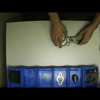
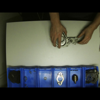
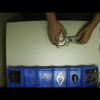
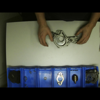
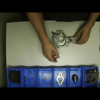
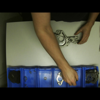
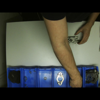
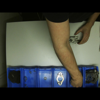
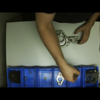

['{\n    "state": "state_0",\n    "action_description": "The person is holding a base block metal piece."\n}']
Frame 115
	True:	0
	Predicted: state_0
	Correct:	 ❌ No
------------------------------
image_paths: ['file:///workspace/dslab25/temp_images/frame_120_original.jpg', 'file:///workspace/dslab25/temp_images/frame_125_original.jpg', 'file:///workspace/dslab25/temp_images/frame_130_original.jpg', 'file:///workspace/dslab25/temp_images/frame_135_original.jpg', 'file:///workspace/dslab25/temp_images/frame_140_original.jpg', 'file:///workspace/dslab25/temp_images/frame_145_original.jpg', 'file:///workspace/dslab25/temp_images/frame_150_original.jpg', 'file:///workspace/dslab25/temp_images/frame_155_original.jpg', 'file:///workspace/dslab25/temp_images/frame_160_original.jpg']



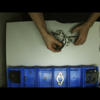
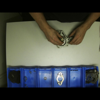
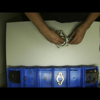
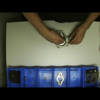
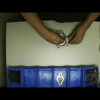
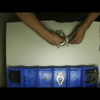
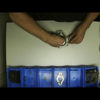
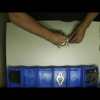
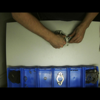

['{\n    "state": "state_1",\n    "action_description": "The person is placing a cylinder metal piece onto the base block."\n}']
Frame 160
	True:	0
	Predicted: state_1
	Correct:	 ❌ No
------------------------------
image_paths: ['file:///workspace/dslab25/temp_images/frame_165_original.jpg', 'file:///workspace/dslab25/temp_images/frame_170_original.jpg', 'file:///workspace/dslab25/temp_images/frame_175_original.jpg', 'file:///workspace/dslab25/temp_images/frame_180_original.jpg', 'file:///workspace/dslab25/temp_images/frame_185_original.jpg', 'file:///workspace/dslab25/temp_images/frame_190_original.jpg', 'file:///workspace/dslab25/temp_images/frame_195_original.jpg', 'file:///workspace/dslab25/temp_images/frame_200_original.jpg', 'file:///workspace/dslab25/temp_images/frame_205_original.jpg']



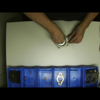
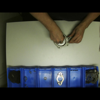
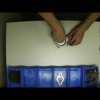
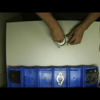
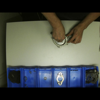
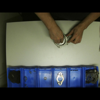
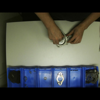
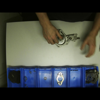
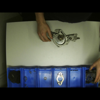

['{\n    "state": "state_1",\n    "action_description": "The person is placing a cylinder metal piece onto the base block."\n}']
Frame 205
	True:	1
	Predicted: state_1
	Correct:	 ❌ No
------------------------------
image_paths: ['file:///workspace/dslab25/temp_images/frame_210_original.jpg', 'file:///workspace/dslab25/temp_images/frame_215_original.jpg', 'file:///workspace/dslab25/temp_images/frame_220_original.jpg', 'file:///workspace/dslab25/temp_images/frame_225_original.jpg', 'file:///workspace/dslab25/temp_images/frame_230_original.jpg', 'file:///workspace/dslab25/temp_images/frame_235_original.jpg', 'file:///workspace/dslab25/temp_images/frame_240_original.jpg', 'file:///workspace/dslab25/temp_images/frame_245_original.jpg', 'file:///workspace/dslab25/temp_images/frame_250_original.jpg']



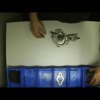
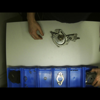
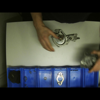
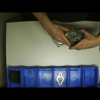
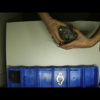
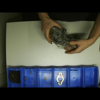
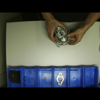
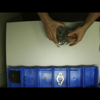
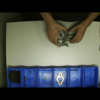

['{\n    "state": "state_1",\n    "action_description": "The person is placing a cylinder metal piece onto the base block."\n}']
Frame 250
	True:	1
	Predicted: state_1
	Correct:	 ❌ No
------------------------------
image_paths: ['file:///workspace/dslab25/temp_images/frame_255_original.jpg', 'file:///workspace/dslab25/temp_images/frame_260_original.jpg', 'file:///workspace/dslab25/temp_images/frame_265_original.jpg', 'file:///workspace/dslab25/temp_images/frame_270_original.jpg', 'file:///workspace/dslab25/temp_images/frame_275_original.jpg', 'file:///workspace/dslab25/temp_images/frame_280_original.jpg', 'file:///workspace/dslab25/temp_images/frame_285_original.jpg', 'file:///workspace/dslab25/temp_images/frame_290_original.jpg', 'file:///workspace/dslab25/temp_images/frame_295_original.jpg']



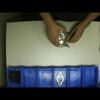
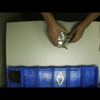
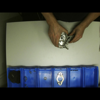
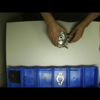
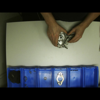
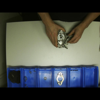
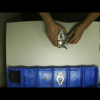
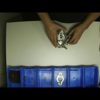
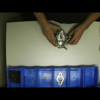

['{\n    "state": "state_1",\n    "action_description": "The person is placing a cylinder metal piece onto the base block."\n}']
Frame 295
	True:	2
	Predicted: state_1
	Correct:	 ❌ No
------------------------------
image_paths: ['file:///workspace/dslab25/temp_images/frame_300_original.jpg', 'file:///workspace/dslab25/temp_images/frame_305_original.jpg', 'file:///workspace/dslab25/temp_images/frame_310_original.jpg', 'file:///workspace/dslab25/temp_images/frame_315_original.jpg', 'file:///workspace/dslab25/temp_images/frame_320_original.jpg', 'file:///workspace/dslab25/temp_images/frame_325_original.jpg', 'file:///workspace/dslab25/temp_images/frame_330_original.jpg', 'file:///workspace/dslab25/temp_images/frame_335_original.jpg', 'file:///workspace/dslab25/temp_images/frame_340_original.jpg']



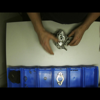
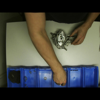
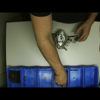
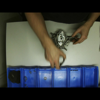
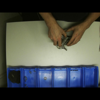
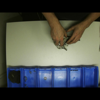
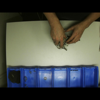
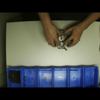
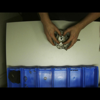

['{\n    "state": "state_1",\n    "action_description": "The person is placing a cylinder metal piece onto the base block."\n}']
Frame 340
	True:	3
	Predicted: state_1
	Correct:	 ❌ No
------------------------------
image_paths: ['file:///workspace/dslab25/temp_images/frame_345_original.jpg', 'file:///workspace/dslab25/temp_images/frame_350_original.jpg', 'file:///workspace/dslab25/temp_images/frame_355_original.jpg', 'file:///workspace/dslab25/temp_images/frame_360_original.jpg', 'file:///workspace/dslab25/temp_images/frame_365_original.jpg', 'file:///workspace/dslab25/temp_images/frame_370_original.jpg', 'file:///workspace/dslab25/temp_images/frame_375_original.jpg', 'file:///workspace/dslab25/temp_images/frame_380_original.jpg', 'file:///workspace/dslab25/temp_images/frame_385_original.jpg']



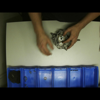
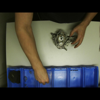
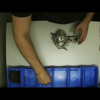
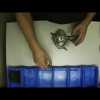
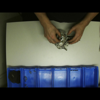
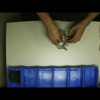
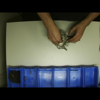
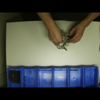
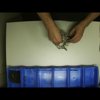

['{\n    "state": "state_1",\n    "action_description": "The person is placing a cylinder metal piece onto the base block."\n}']
Frame 385
	True:	3
	Predicted: state_1
	Correct:	 ❌ No
------------------------------
image_paths: ['file:///workspace/dslab25/temp_images/frame_390_original.jpg', 'file:///workspace/dslab25/temp_images/frame_395_original.jpg', 'file:///workspace/dslab25/temp_images/frame_400_original.jpg', 'file:///workspace/dslab25/temp_images/frame_405_original.jpg', 'file:///workspace/dslab25/temp_images/frame_410_original.jpg', 'file:///workspace/dslab25/temp_images/frame_415_original.jpg', 'file:///workspace/dslab25/temp_images/frame_420_original.jpg', 'file:///workspace/dslab25/temp_images/frame_425_original.jpg', 'file:///workspace/dslab25/temp_images/frame_430_original.jpg']



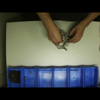
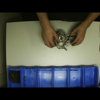
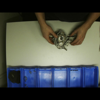
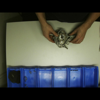
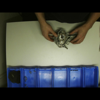
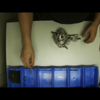
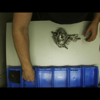
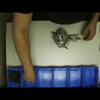
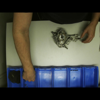

['{\n    "state": "state_1",\n    "action_description": "The person is placing a cylinder metal piece onto the base block."\n}']
Frame 430
	True:	4
	Predicted: state_1
	Correct:	 ❌ No
------------------------------
image_paths: ['file:///workspace/dslab25/temp_images/frame_435_original.jpg', 'file:///workspace/dslab25/temp_images/frame_440_original.jpg', 'file:///workspace/dslab25/temp_images/frame_445_original.jpg', 'file:///workspace/dslab25/temp_images/frame_450_original.jpg', 'file:///workspace/dslab25/temp_images/frame_455_original.jpg', 'file:///workspace/dslab25/temp_images/frame_460_original.jpg', 'file:///workspace/dslab25/temp_images/frame_465_original.jpg', 'file:///workspace/dslab25/temp_images/frame_470_original.jpg', 'file:///workspace/dslab25/temp_images/frame_475_original.jpg']



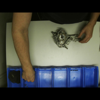
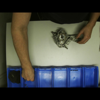
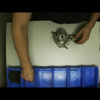
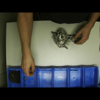
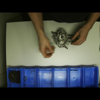
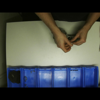
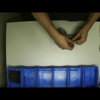
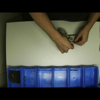
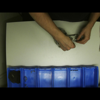

['{\n    "state": "state_1",\n    "action_description": "The person is placing a cylinder metal piece onto the base block."\n}']
Frame 475
	True:	4
	Predicted: state_1
	Correct:	 ❌ No
------------------------------
image_paths: ['file:///workspace/dslab25/temp_images/frame_480_original.jpg', 'file:///workspace/dslab25/temp_images/frame_485_original.jpg', 'file:///workspace/dslab25/temp_images/frame_490_original.jpg', 'file:///workspace/dslab25/temp_images/frame_495_original.jpg', 'file:///workspace/dslab25/temp_images/frame_500_original.jpg', 'file:///workspace/dslab25/temp_images/frame_505_original.jpg', 'file:///workspace/dslab25/temp_images/frame_510_original.jpg', 'file:///workspace/dslab25/temp_images/frame_515_original.jpg', 'file:///workspace/dslab25/temp_images/frame_520_original.jpg']



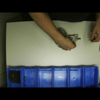
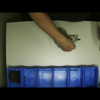
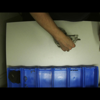
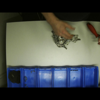
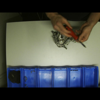
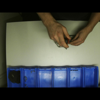
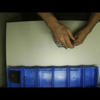
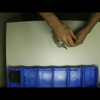
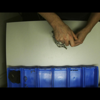

['{\n    "state": "state_1",\n    "action_description": "The person is placing a cylinder metal piece onto the base block."\n}']
Frame 520
	True:	5
	Predicted: state_1
	Correct:	 ❌ No
------------------------------
image_paths: ['file:///workspace/dslab25/temp_images/frame_525_original.jpg', 'file:///workspace/dslab25/temp_images/frame_530_original.jpg', 'file:///workspace/dslab25/temp_images/frame_535_original.jpg', 'file:///workspace/dslab25/temp_images/frame_540_original.jpg', 'file:///workspace/dslab25/temp_images/frame_545_original.jpg', 'file:///workspace/dslab25/temp_images/frame_550_original.jpg', 'file:///workspace/dslab25/temp_images/frame_555_original.jpg', 'file:///workspace/dslab25/temp_images/frame_560_original.jpg', 'file:///workspace/dslab25/temp_images/frame_565_original.jpg']



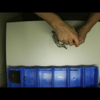
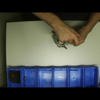
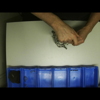
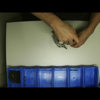
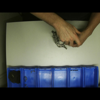
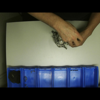
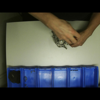
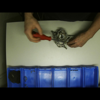
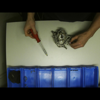

['{\n    "state": "state_1",\n    "action_description": "The person is placing a cylinder metal piece onto the base block."\n}']
Frame 565
	True:	5
	Predicted: state_1
	Correct:	 ❌ No
------------------------------
image_paths: ['file:///workspace/dslab25/temp_images/frame_570_original.jpg', 'file:///workspace/dslab25/temp_images/frame_575_original.jpg', 'file:///workspace/dslab25/temp_images/frame_580_original.jpg', 'file:///workspace/dslab25/temp_images/frame_585_original.jpg', 'file:///workspace/dslab25/temp_images/frame_590_original.jpg', 'file:///workspace/dslab25/temp_images/frame_595_original.jpg', 'file:///workspace/dslab25/temp_images/frame_600_original.jpg', 'file:///workspace/dslab25/temp_images/frame_605_original.jpg', 'file:///workspace/dslab25/temp_images/frame_610_original.jpg']



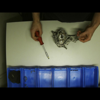
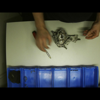
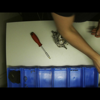
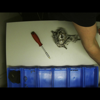
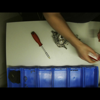
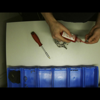
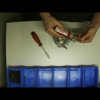
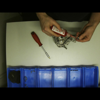
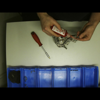

['{\n    "state": "state_1",\n    "action_description": "The person is placing a cylinder metal piece onto the base block."\n}']
Frame 610
	True:	5
	Predicted: state_1
	Correct:	 ❌ No
------------------------------
image_paths: ['file:///workspace/dslab25/temp_images/frame_615_original.jpg', 'file:///workspace/dslab25/temp_images/frame_620_original.jpg', 'file:///workspace/dslab25/temp_images/frame_625_original.jpg', 'file:///workspace/dslab25/temp_images/frame_630_original.jpg', 'file:///workspace/dslab25/temp_images/frame_635_original.jpg', 'file:///workspace/dslab25/temp_images/frame_640_original.jpg', 'file:///workspace/dslab25/temp_images/frame_645_original.jpg', 'file:///workspace/dslab25/temp_images/frame_650_original.jpg', 'file:///workspace/dslab25/temp_images/frame_655_original.jpg']



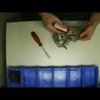
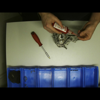
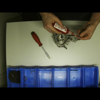
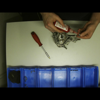
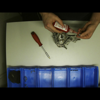
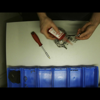
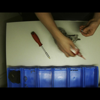
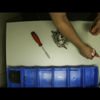
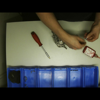

['{\n    "state": "state_1",\n    "action_description": "The person is applying a red substance from a bottle onto the cylinder metal piece."\n}']
Frame 655
	True:	5
	Predicted: state_1
	Correct:	 ❌ No
------------------------------
image_paths: ['file:///workspace/dslab25/temp_images/frame_660_original.jpg', 'file:///workspace/dslab25/temp_images/frame_665_original.jpg', 'file:///workspace/dslab25/temp_images/frame_670_original.jpg', 'file:///workspace/dslab25/temp_images/frame_675_original.jpg', 'file:///workspace/dslab25/temp_images/frame_680_original.jpg', 'file:///workspace/dslab25/temp_images/frame_685_original.jpg', 'file:///workspace/dslab25/temp_images/frame_690_original.jpg', 'file:///workspace/dslab25/temp_images/frame_695_original.jpg', 'file:///workspace/dslab25/temp_images/frame_700_original.jpg']



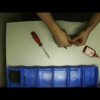
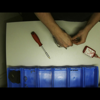
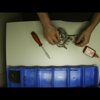
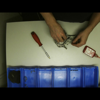
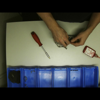
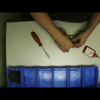
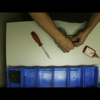
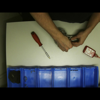
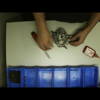

['{\n    "state": "state_1",\n    "action_description": "The person is applying a red substance from a bottle onto the cylinder metal piece."\n}']
Frame 700
	True:	5
	Predicted: state_1
	Correct:	 ❌ No
------------------------------
image_paths: ['file:///workspace/dslab25/temp_images/frame_705_original.jpg', 'file:///workspace/dslab25/temp_images/frame_710_original.jpg', 'file:///workspace/dslab25/temp_images/frame_715_original.jpg', 'file:///workspace/dslab25/temp_images/frame_720_original.jpg', 'file:///workspace/dslab25/temp_images/frame_725_original.jpg', 'file:///workspace/dslab25/temp_images/frame_730_original.jpg', 'file:///workspace/dslab25/temp_images/frame_735_original.jpg', 'file:///workspace/dslab25/temp_images/frame_740_original.jpg', 'file:///workspace/dslab25/temp_images/frame_745_original.jpg']



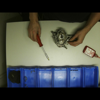
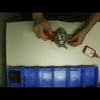
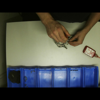
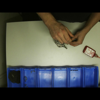
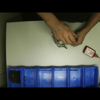
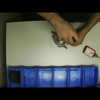
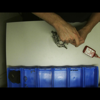
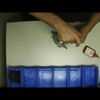
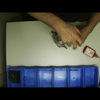

['{\n    "state": "state_1",\n    "action_description": "The person is applying a red substance from a bottle onto the cylinder metal piece."\n}']
Frame 745
	True:	5
	Predicted: state_1
	Correct:	 ❌ No
------------------------------
image_paths: ['file:///workspace/dslab25/temp_images/frame_750_original.jpg', 'file:///workspace/dslab25/temp_images/frame_755_original.jpg', 'file:///workspace/dslab25/temp_images/frame_760_original.jpg', 'file:///workspace/dslab25/temp_images/frame_765_original.jpg', 'file:///workspace/dslab25/temp_images/frame_770_original.jpg', 'file:///workspace/dslab25/temp_images/frame_775_original.jpg', 'file:///workspace/dslab25/temp_images/frame_780_original.jpg', 'file:///workspace/dslab25/temp_images/frame_785_original.jpg', 'file:///workspace/dslab25/temp_images/frame_790_original.jpg']



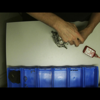
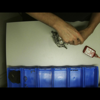
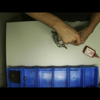
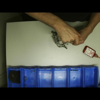
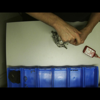
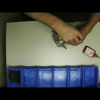
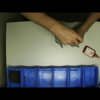
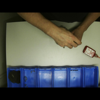
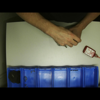

['{\n    "state": "state_1",\n    "action_description": "The person is applying a red substance from a bottle onto the cylinder metal piece."\n}']
Frame 790
	True:	5
	Predicted: state_1
	Correct:	 ❌ No
------------------------------
image_paths: ['file:///workspace/dslab25/temp_images/frame_795_original.jpg', 'file:///workspace/dslab25/temp_images/frame_800_original.jpg', 'file:///workspace/dslab25/temp_images/frame_805_original.jpg', 'file:///workspace/dslab25/temp_images/frame_810_original.jpg', 'file:///workspace/dslab25/temp_images/frame_815_original.jpg', 'file:///workspace/dslab25/temp_images/frame_820_original.jpg', 'file:///workspace/dslab25/temp_images/frame_825_original.jpg', 'file:///workspace/dslab25/temp_images/frame_830_original.jpg', 'file:///workspace/dslab25/temp_images/frame_835_original.jpg']



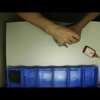
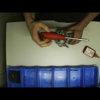
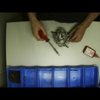
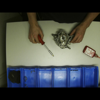
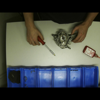
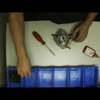
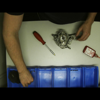
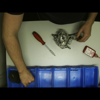
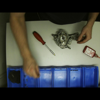

['{\n    "state": "state_1",\n    "action_description": "The person is applying a red substance from a bottle onto the cylinder metal piece."\n}']
Frame 835
	True:	5
	Predicted: state_1
	Correct:	 ❌ No
------------------------------
image_paths: ['file:///workspace/dslab25/temp_images/frame_840_original.jpg', 'file:///workspace/dslab25/temp_images/frame_845_original.jpg', 'file:///workspace/dslab25/temp_images/frame_850_original.jpg', 'file:///workspace/dslab25/temp_images/frame_855_original.jpg', 'file:///workspace/dslab25/temp_images/frame_860_original.jpg', 'file:///workspace/dslab25/temp_images/frame_865_original.jpg', 'file:///workspace/dslab25/temp_images/frame_870_original.jpg', 'file:///workspace/dslab25/temp_images/frame_875_original.jpg', 'file:///workspace/dslab25/temp_images/frame_880_original.jpg']



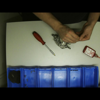
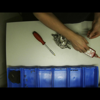
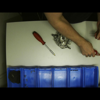
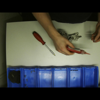
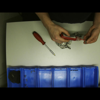
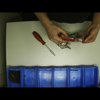
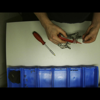
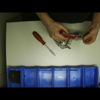
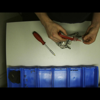

['{\n    "state": "state_1",\n    "action_description": "The person is applying a red substance from a bottle onto the cylinder metal piece."\n}']
Frame 880
	True:	5
	Predicted: state_1
	Correct:	 ❌ No
------------------------------
image_paths: ['file:///workspace/dslab25/temp_images/frame_885_original.jpg', 'file:///workspace/dslab25/temp_images/frame_890_original.jpg', 'file:///workspace/dslab25/temp_images/frame_895_original.jpg', 'file:///workspace/dslab25/temp_images/frame_900_original.jpg', 'file:///workspace/dslab25/temp_images/frame_905_original.jpg', 'file:///workspace/dslab25/temp_images/frame_910_original.jpg', 'file:///workspace/dslab25/temp_images/frame_915_original.jpg', 'file:///workspace/dslab25/temp_images/frame_920_original.jpg', 'file:///workspace/dslab25/temp_images/frame_925_original.jpg']



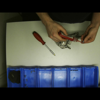
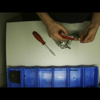
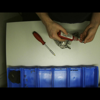
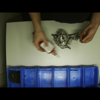
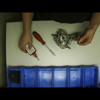
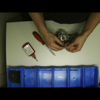
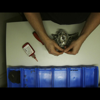
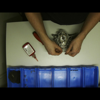
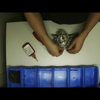

['{\n    "state": "state_1",\n    "action_description": "The person is applying a red substance from a bottle onto the cylinder metal piece."\n}']
Frame 925
	True:	5
	Predicted: state_1
	Correct:	 ❌ No
------------------------------
image_paths: ['file:///workspace/dslab25/temp_images/frame_930_original.jpg', 'file:///workspace/dslab25/temp_images/frame_935_original.jpg', 'file:///workspace/dslab25/temp_images/frame_940_original.jpg', 'file:///workspace/dslab25/temp_images/frame_945_original.jpg', 'file:///workspace/dslab25/temp_images/frame_950_original.jpg', 'file:///workspace/dslab25/temp_images/frame_955_original.jpg', 'file:///workspace/dslab25/temp_images/frame_960_original.jpg', 'file:///workspace/dslab25/temp_images/frame_965_original.jpg', 'file:///workspace/dslab25/temp_images/frame_970_original.jpg']



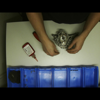
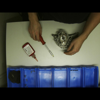
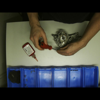
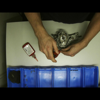
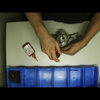
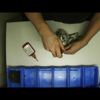
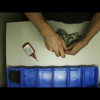
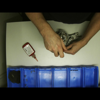
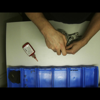

['{\n    "state": "state_1",\n    "action_description": "The person is applying a red substance from a bottle onto the cylinder metal piece."\n}']
Frame 970
	True:	5
	Predicted: state_1
	Correct:	 ❌ No
------------------------------
image_paths: ['file:///workspace/dslab25/temp_images/frame_975_original.jpg', 'file:///workspace/dslab25/temp_images/frame_980_original.jpg', 'file:///workspace/dslab25/temp_images/frame_985_original.jpg', 'file:///workspace/dslab25/temp_images/frame_990_original.jpg', 'file:///workspace/dslab25/temp_images/frame_995_original.jpg', 'file:///workspace/dslab25/temp_images/frame_1000_original.jpg', 'file:///workspace/dslab25/temp_images/frame_1005_original.jpg', 'file:///workspace/dslab25/temp_images/frame_1010_original.jpg', 'file:///workspace/dslab25/temp_images/frame_1015_original.jpg']



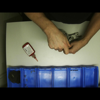
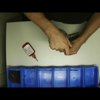
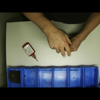
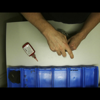
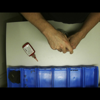
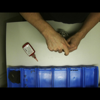
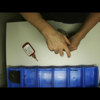
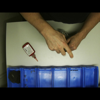
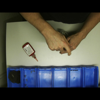

['{\n    "state": "state_1",\n    "action_description": "The person is applying a red substance from a bottle onto the cylinder metal piece."\n}']
Frame 1015
	True:	5
	Predicted: state_1
	Correct:	 ❌ No
------------------------------
image_paths: ['file:///workspace/dslab25/temp_images/frame_1020_original.jpg', 'file:///workspace/dslab25/temp_images/frame_1025_original.jpg', 'file:///workspace/dslab25/temp_images/frame_1030_original.jpg', 'file:///workspace/dslab25/temp_images/frame_1035_original.jpg', 'file:///workspace/dslab25/temp_images/frame_1040_original.jpg', 'file:///workspace/dslab25/temp_images/frame_1045_original.jpg', 'file:///workspace/dslab25/temp_images/frame_1050_original.jpg', 'file:///workspace/dslab25/temp_images/frame_1055_original.jpg', 'file:///workspace/dslab25/temp_images/frame_1060_original.jpg']



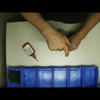
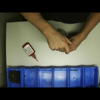
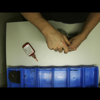
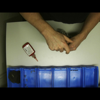
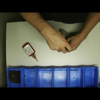
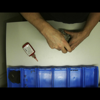
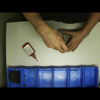
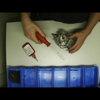
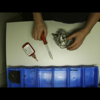

['{\n    "state": "state_1",\n    "action_description": "The person is applying a red substance from a bottle onto the cylinder metal piece."\n}']
Frame 1060
	True:	5
	Predicted: state_1
	Correct:	 ❌ No
------------------------------
image_paths: ['file:///workspace/dslab25/temp_images/frame_1065_original.jpg', 'file:///workspace/dslab25/temp_images/frame_1070_original.jpg', 'file:///workspace/dslab25/temp_images/frame_1075_original.jpg', 'file:///workspace/dslab25/temp_images/frame_1080_original.jpg', 'file:///workspace/dslab25/temp_images/frame_1085_original.jpg', 'file:///workspace/dslab25/temp_images/frame_1090_original.jpg', 'file:///workspace/dslab25/temp_images/frame_1095_original.jpg', 'file:///workspace/dslab25/temp_images/frame_1100_original.jpg', 'file:///workspace/dslab25/temp_images/frame_1105_original.jpg']



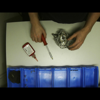
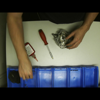
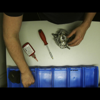
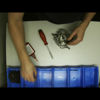
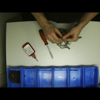
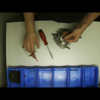
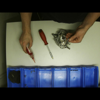
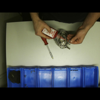
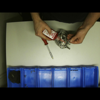

['{\n    "state": "state_1",\n    "action_description": "The person is applying a red substance from a bottle onto the cylinder metal piece."\n}']
Frame 1105
	True:	5
	Predicted: state_1
	Correct:	 ❌ No
------------------------------
image_paths: ['file:///workspace/dslab25/temp_images/frame_1110_original.jpg', 'file:///workspace/dslab25/temp_images/frame_1115_original.jpg', 'file:///workspace/dslab25/temp_images/frame_1120_original.jpg', 'file:///workspace/dslab25/temp_images/frame_1125_original.jpg', 'file:///workspace/dslab25/temp_images/frame_1130_original.jpg', 'file:///workspace/dslab25/temp_images/frame_1135_original.jpg', 'file:///workspace/dslab25/temp_images/frame_1140_original.jpg', 'file:///workspace/dslab25/temp_images/frame_1145_original.jpg', 'file:///workspace/dslab25/temp_images/frame_1150_original.jpg']



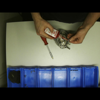
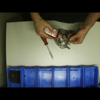
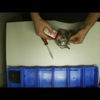
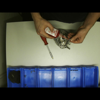
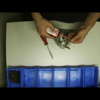
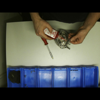
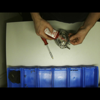
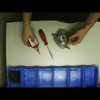
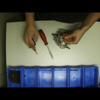

['{\n    "state": "state_1",\n    "action_description": "The person is applying a red substance from a bottle onto the cylinder metal piece."\n}']
Frame 1150
	True:	5
	Predicted: state_1
	Correct:	 ❌ No
------------------------------
image_paths: ['file:///workspace/dslab25/temp_images/frame_1155_original.jpg', 'file:///workspace/dslab25/temp_images/frame_1160_original.jpg', 'file:///workspace/dslab25/temp_images/frame_1165_original.jpg', 'file:///workspace/dslab25/temp_images/frame_1170_original.jpg', 'file:///workspace/dslab25/temp_images/frame_1175_original.jpg', 'file:///workspace/dslab25/temp_images/frame_1180_original.jpg', 'file:///workspace/dslab25/temp_images/frame_1185_original.jpg', 'file:///workspace/dslab25/temp_images/frame_1190_original.jpg', 'file:///workspace/dslab25/temp_images/frame_1195_original.jpg']



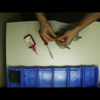
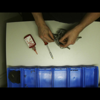
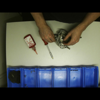
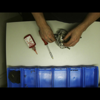
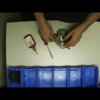
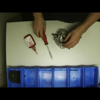
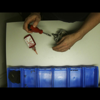
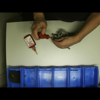
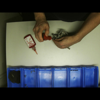

['{\n    "state": "state_1",\n    "action_description": "The person is applying a red substance from a bottle onto the cylinder metal piece."\n}']
Frame 1195
	True:	5
	Predicted: state_1
	Correct:	 ❌ No
------------------------------
image_paths: ['file:///workspace/dslab25/temp_images/frame_1200_original.jpg', 'file:///workspace/dslab25/temp_images/frame_1205_original.jpg', 'file:///workspace/dslab25/temp_images/frame_1210_original.jpg', 'file:///workspace/dslab25/temp_images/frame_1215_original.jpg', 'file:///workspace/dslab25/temp_images/frame_1220_original.jpg', 'file:///workspace/dslab25/temp_images/frame_1225_original.jpg', 'file:///workspace/dslab25/temp_images/frame_1230_original.jpg', 'file:///workspace/dslab25/temp_images/frame_1235_original.jpg', 'file:///workspace/dslab25/temp_images/frame_1240_original.jpg']



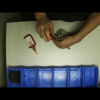
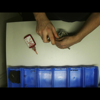
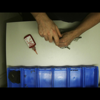
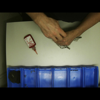
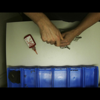
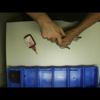
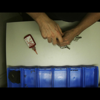
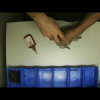
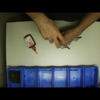

KeyboardInterrupt: 

In [18]:
# Messages containing a local video path and a text query

def display_images_horizontal(image_paths, size=(100, 100)):
    html = '<div style="display: flex; flex-direction: row;">'
    for path in image_paths:
        img = Image.open(path).resize(size)
        buffer = io.BytesIO()
        img.save(buffer, format='PNG')
        img_str = base64.b64encode(buffer.getvalue()).decode("utf-8")
        html += f'<img src="data:image/png;base64,{img_str}" style="margin:2px;" />'
    html += '</div>'
    display(HTML(html))
    
def qwen_vl(image_paths: list[str], current_dino_state: str, previous_qwen_state: str, previous_information: str):
	"""
	[
		"file:///path/to/frame1.jpg",
		"file:///path/to/frame2.jpg",
		"file:///path/to/frame3.jpg",
		"file:///path/to/frame4.jpg",
	],
	"""
	messages = [
		{
			"role": "user",
			"content": [
			{
				"type": "video",
				"video": image_paths
			},
			{
				"type": "text",
				"text": f'''
					You are given a short video clip of a person assembling an object. The clip is part of a longer clip of the person assembling the object.
                    Your task is it to tell me what you see in the video and based on that and the previous action, some more information below make a prediction on which state the piece is at the end of the clip.
                    Note that the clip may end while the person is still in the middle of an action.
					If the state is in between two states, return the state it was in before, so if the person is moving the cylinder piece to the base block, return state_0, only when the cylinder piece is on the base block, return state_1.
					Here are the possible states:
						'state_0': 'First part of the object: Base block metal piece',
						'state_1': 'Second part of the object: Cylinder metal piece which gets stick on the base block stage_0',
						'state_2': 'Third part of the object: A Big metal piece which gets stick on the cylinder piece of stage_1',
						'state_3': 'Fourth part of the object: A smaller thin metal piece which gets put onto the center of the big metal piece of stage_2',
						'state_4': 'Fifth part of the object: A tiny metal ring which gets placed onto the center of the thing metal piece of stage_3',
						'state_5': 'Sixth part of the object: 3 screws now get screwed onto the piece',
						'state_6': 'Seventh part of the object: A darker metal plate now gets placed on top of the piece',
						'state_7': 'Eighth part of the object: 5 screws now get screwed onto the piece'
					Additionally I will give you the state in which the classifier thinks the piece is at.
					Here is the information (it might be none id it didnt predict anything):
						{current_dino_state}
					Additionally I will give you the state in which the classifier thinks the piece was at at the beginning of the clip.
					Here is the information ((it might be none id it didnt predict anything)):
						{previous_qwen_state}
					Additionally, I will give you some information about what the person did 5 seconds before the clip starts.
					Here is the information:
						{previous_information}

					Please return the output in the following format:
					{{
						"state": "state_name",
						"action_description": "action_description"
					}}
				'''},
				],
			}
		]

	text = qwen_vl_processor.apply_chat_template(
		messages, tokenize=False, add_generation_prompt=True
	)
	image_inputs, video_inputs = process_vision_info(messages)
	inputs = qwen_vl_processor(
		text=[text],
		images=image_inputs,
		videos=video_inputs,
		fps=fps,
		padding=True,
		return_tensors="pt",
		
	)
	inputs = inputs.to("cuda")

	# Inference
	generated_ids = qwen_vl_model.generate(**inputs, max_new_tokens=128)
	generated_ids_trimmed = [
		out_ids[len(in_ids) :] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
	]
	output_text = qwen_vl_processor.batch_decode(
		generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
	)
	print(output_text)
	return output_text

previous_qwen_state = "None because its the first clip"
previous_information = "None because its the first clip"
current_dino_state = "None because its the first clip"

correct_predictions = 0
total_predictions = 0

for idx in range(0, len(frames_to_process), 9):
	image_paths = []
	for frame_idx, frame in frames_to_process[idx:idx+9]:
		frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
		image = Image.fromarray(frame_rgb)
		image_path = os.path.join(temp_images_dir, f"frame_{frame_idx}_original.jpg")
		image.save(image_path)
		image_paths.append(f'file://{image_path}')
	print("image_paths:", image_paths)
	# yolo_results = yolo_model(frame)
	# skip_to_qwen = False
	# if len(yolo_results) == 0 or len(yolo_results[0].boxes) == 0:
	# 	print(f"Frame {frame_idx}: No detection found. Skipping frame.")
	# 	skip_to_qwen = True
	true_label = frame_to_class[frame_idx]
	true_label_name = category_id_to_name.get(true_label, f"Class_{true_label}")
	if not True:
		boxes = yolo_results[0].boxes.data	# Each row: [x1, y1, x2, y2, conf, cls]

		# Find the box with the highest confidence
		highest_conf_idx = -1
		highest_conf = 0

		for idx, box in enumerate(boxes):
			confidence = box[4].item()
			if confidence < YOL_THRESHOLD:
				continue
			
			if confidence > highest_conf:
				highest_conf = confidence
				highest_conf_idx = idx
		
		if highest_conf_idx >= 0:
			box = boxes[highest_conf_idx]
			confidence = box[4].item()
			predicted_label = int(box[5].item())
			current_dino_state = category_id_to_name.get(predicted_label, f"Class_{predicted_label}")
			
			x1, y1, x2, y2 = map(int, box[:4].tolist())
			x1 = max(0, x1)
			y1 = max(0, y1)
			x2 = min(image.width, x2)
			y2 = min(image.height, y2)
			
			cropped_image = image.crop((x1, y1, x2, y2))
			cropped_path = os.path.join(temp_images_dir, f"frame_{frame_idx}.jpg")
			cropped_image.save(cropped_path)
			
			print(f"Saved cropped image: {cropped_path}")
		else:
			current_dino_state = "None, Dino didnt make a prediction"
			
	display_images_horizontal([img.replace('file://', '') for img in image_paths])
	res = qwen_vl(image_paths, current_dino_state, previous_qwen_state, previous_information)[0]
	res = json.loads(res)

	previous_qwen_state = res["state"]
	previous_information = res["action_description"]
	predicted_label = previous_qwen_state
	is_correct = labels_match(previous_qwen_state, true_label)
	if is_correct:
		correct_predictions += 1
	total_predictions += 1

	print(f"Frame {frame_idx}")
	print(f"	True:	{true_label}")
	print(f"	Predicted: {predicted_label}")
	print(f"	Correct:	 {'✅ Yes' if is_correct else '❌ No'}")
	print("-" * 30)



accuracy = correct_predictions / total_predictions if total_predictions > 0 else 0
print("\nEvaluation Summary:")
print(f"	Total predictions: {total_predictions}")
print(f"	Correct predictions: {correct_predictions}")
print(f"	Accuracy: {accuracy:.2f}")
